In [1]:
library(tidyverse)
library(magrittr)
library(martini)
library(cowplot)

load(file = "../datasets/genesis/genesis.RData")

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats

Attaching package: ‘magrittr’

The following object is masked from ‘package:purrr’:

    set_names

The following object is masked from ‘package:tidyr’:

    extract

Loading required package: Matrix

Attaching package: ‘Matrix’

The following object is masked from ‘package:tidyr’:

    expand

Loading required package: igraph

Attaching package: ‘igraph’

The following object is masked from ‘package:magrittr’:

    %>%

The following objects are masked from ‘package:dplyr’:

    %>%, as_data_frame, groups, union

The following objects are masked from ‘package:purrr’:

    %>%, compose, simplify

The following objects are masked from ‘package:tidyr’:

    %>%, crossing

The following object is masked from ‘pac

# Data exploration

In [2]:
summary(genesis$genotype)

$rows
   Call.rate Certain.calls Heterozygosity  
 Min.   :1   Min.   :1     Min.   :0.2663  
 1st Qu.:1   1st Qu.:1     1st Qu.:0.3138  
 Median :1   Median :1     Median :0.3161  
 Mean   :1   Mean   :1     Mean   :0.3159  
 3rd Qu.:1   3rd Qu.:1     3rd Qu.:0.3184  
 Max.   :1   Max.   :1     Max.   :0.3290  

$cols
     Calls        Call.rate Certain.calls      RAF           
 Min.   :2566   Min.   :1   Min.   :1     Min.   :0.0009743  
 1st Qu.:2566   1st Qu.:1   1st Qu.:1     1st Qu.:0.1095090  
 Median :2566   Median :1   Median :1     Median :0.2373344  
 Mean   :2566   Mean   :1   Mean   :1     Mean   :0.2882514  
 3rd Qu.:2566   3rd Qu.:1   3rd Qu.:1     3rd Qu.:0.4269291  
 Max.   :2566   Max.   :1   Max.   :1     Max.   :0.9988309  
      MAF                 P.AA             P.AB               P.BB        
 Min.   :0.0009743   Min.   :0.0000   Min.   :0.001949   Min.   :0.00000  
 1st Qu.:0.1069758   1st Qu.:0.3289   1st Qu.:0.190569   1st Qu.:0.01208  
 Median :0.2205768  

In [3]:
snpsum <- col.summary(genesis$genotype)

In [4]:
subject.info <- data.frame(cc = genesis$fam$affected, stratum = rep("EUR", nrow(genesis$fam)))

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


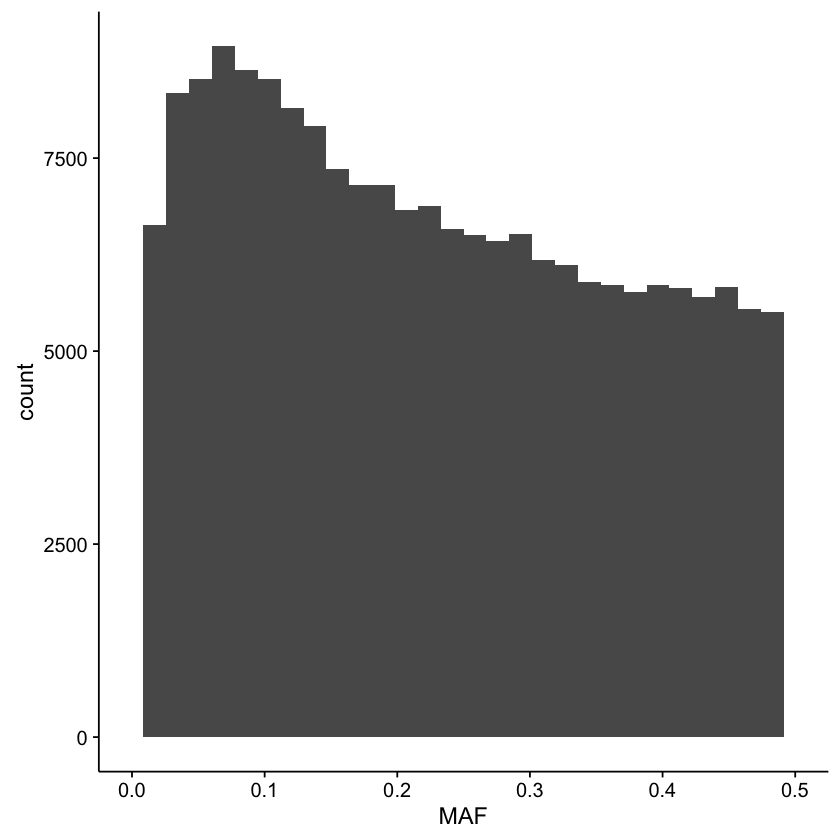

In [5]:
ggplot(snpsum, aes(x = MAF)) + 
    geom_histogram() +
    lims(x = c(0, 0.5))

# GWAS

In [6]:
tests <- single.snp.tests(genesis$fam$affected, 
                          data = subject.info, 
                          snp.data = genesis$genotypes)

tests.info <- genesis$map %>%
    rename(chr = V1, gpos = V4) %>%
    mutate(p = p.value(tests, df=1),
           adjp = p.adjust(p))

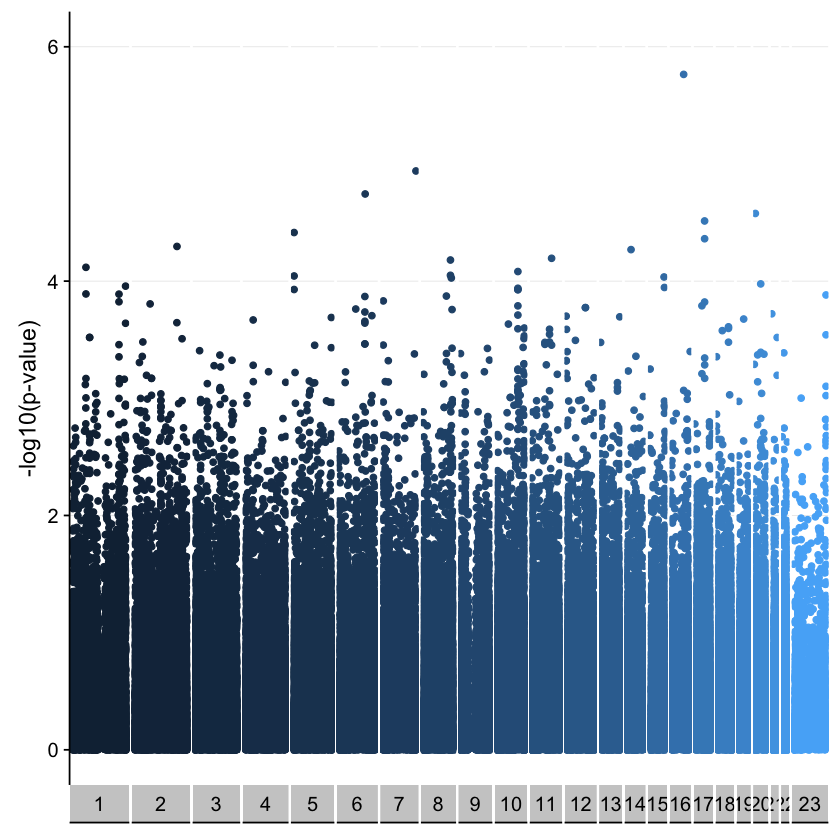

In [7]:
ggplot(tests.info, aes(x = gpos, y = -log10(p), color = chr)) +
    geom_point() +
    background_grid(major = "y", minor = "none") +
    theme(axis.text.x = element_blank(),
          axis.title.x=element_blank(),
          axis.ticks.x=element_blank(),
          legend.position = "none",
          panel.spacing.x = unit(0.1, "lines") ) +
    labs(x = "Genomic position", y = "-log10(p-value)") +
    lims(y = c(0, 6)) +
    facet_grid(. ~ chr, scales = "free_x", space = "free_x", switch = "x")

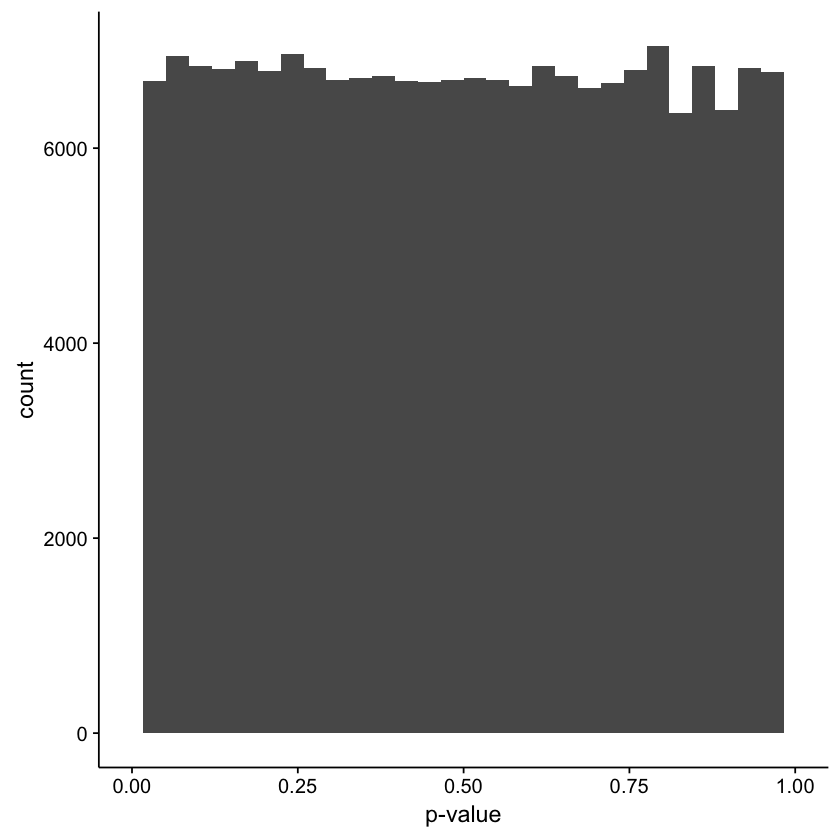

In [8]:
ggplot(tests.info, aes(x = p)) +
    geom_histogram(bins = 30) +
    lims(x = c(0,1)) +
    labs(x = "p-value")

In [10]:
bonferroni.threshold <- 0.05/nrow(genesis$map)
sum(tests.info$p < bonferroni.threshold)

[1] 0

In [11]:
sum(tests.info$adjp < 0.05)

[1] 0

# Population structure

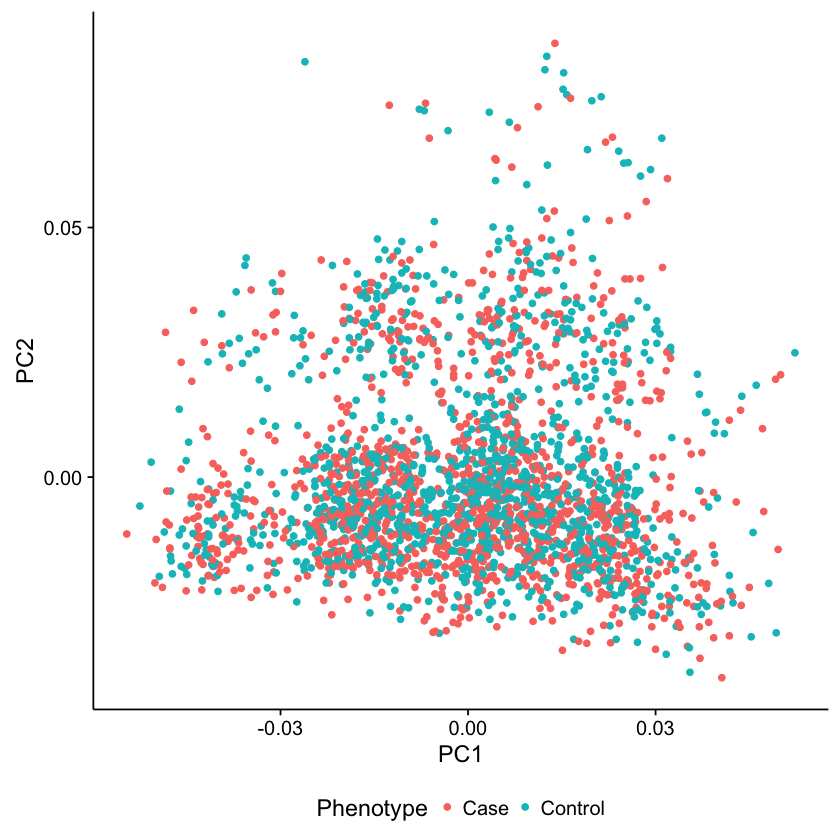

In [12]:
ev <- read.delim("../results/population_structure/genesis.processed.pca.evec", 
                 sep = "", header = F, skip = 1)
ncols <- ncol(ev)
colnames(ev) <- c("sample", paste0("pc", seq(1, ncols - 2)), "phenotype")

ggplot(ev, aes(x = pc1, y = pc2, color = phenotype)) +
    geom_point() +
    labs(x = "PC1", y = "PC2", color = "Phenotype") +
    theme(legend.position = "bottom")

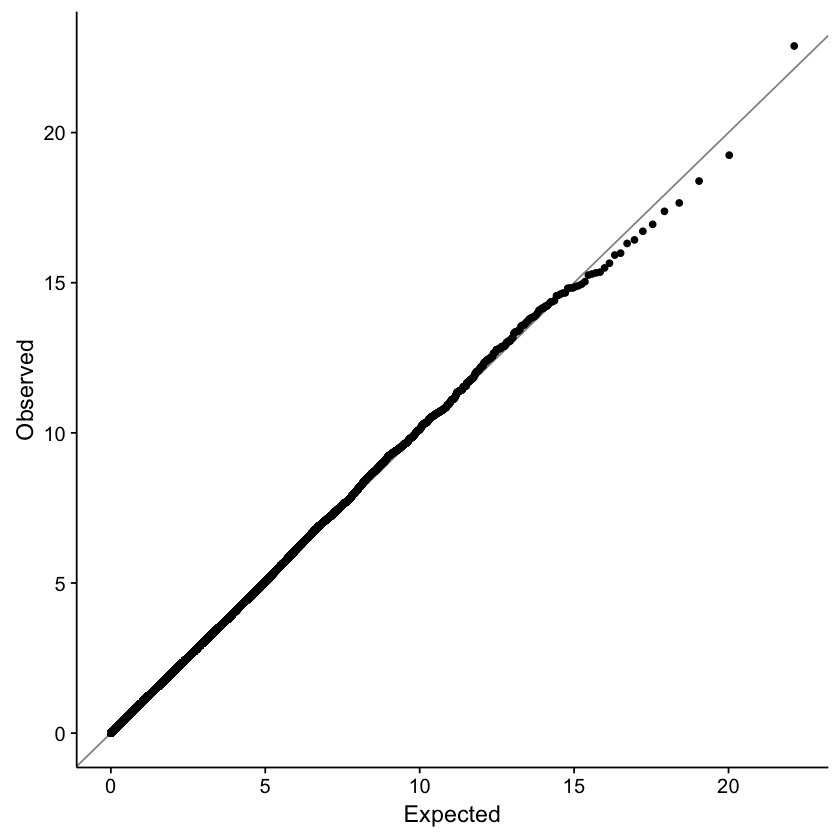

In [13]:
chi2 <- chi.squared(tests, df=1)

ggplot(as.data.frame(chi2), aes(sample = chi2)) +
    geom_qq(distribution = stats::qchisq, dparams = list(df = 1)) +
    geom_abline(intercept = 0, slope = 1, alpha = 0.5) +
    labs(x = "Expected", y = "Observed")

# SConES

In [14]:
getSnpTrack <- function(map, selected, name = "SNP"){
  library(Gviz)
  
  s <- which(selected)
  f <- head(s, n=1) - 5
  l <- tail(s, n=1) + 5
  
  snpPlot <- map[f:l,]
  snps <- selected[f:l]
  
  snpRange <- GRanges(seqnames = paste0("chr", snpPlot$chr), 
                      ranges = IRanges(start = snpPlot$gpos, 
                                       end = snpPlot$gpos) )
  genome(snpRange) <- "hg19"
  snpTrack <- AnnotationTrack(snpRange, name = name, stacking ="dense")
  feature(snpTrack) <- ifelse(snps, "Selected", "Unselected")
  
  return(snpTrack)
}

In [15]:
gs <- read_tsv("../results/scones/gs/scones_gs.out.txt", 
               col_names = F,  comment = "#", col_types = "cii") %>%
  set_colnames(c("id", "chr", "gpos"))

gm <- read_tsv("../results/scones/gm/scones_gm.out.txt", 
               col_names = F,  comment = "#", col_types = "cii") %>%
  set_colnames(c("id", "chr", "gpos"))

gi <- read_tsv("../results/scones/gi/scones_gi.out.txt", 
               col_names = F,  comment = "#", col_types = "cii") %>%
  set_colnames(c("id", "chr", "gpos"))

map <- read_tsv("../datasets/genesis/genesis.processed.map", 
                col_names = F, col_types = "icii") %>%
        set_colnames(c("chr","id","X","gpos")) %>% 
        arrange(chr, gpos) %>%
        mutate(gs = id %in% gs$id,
               gi = id %in% gi$id,
               gm = id %in% gm$id)

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:igraph’:

    normalize, union

The following object is masked from ‘package:Matrix’:

    which

The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union

The following objects are masked from ‘package:stats’:

    IQR, mad, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colnames, do.call,
    duplicated, eval, evalq, Filter, Find, get, grep, grepl, intersect,
    is.unsorted, lapply, lengths, Map, mapply, match, mget, order,
    pa

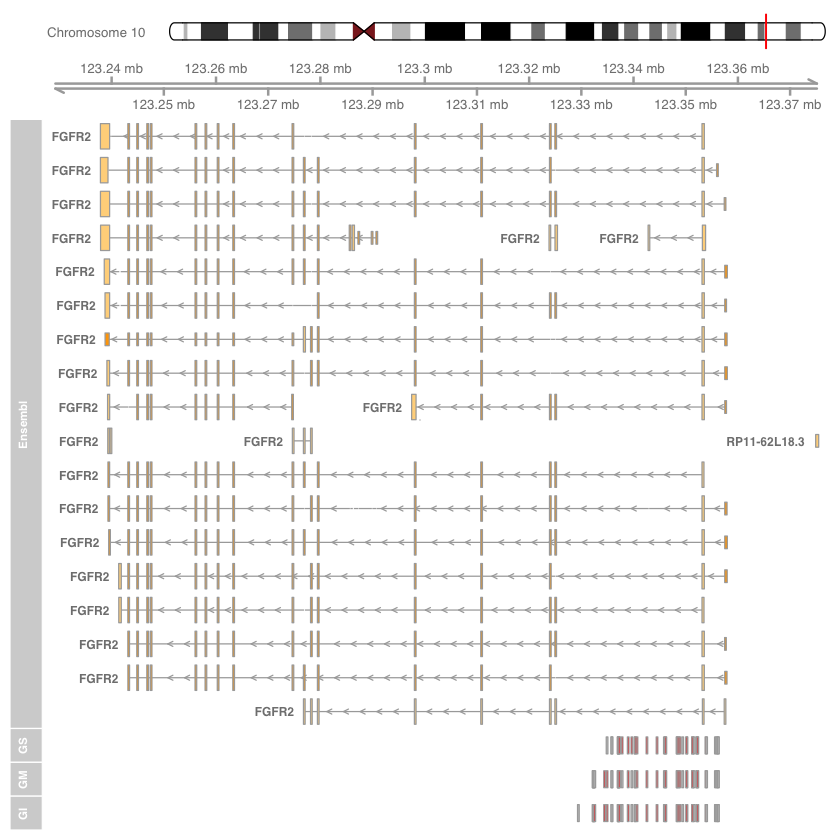

In [16]:
map10 <- map %>%
        filter(chr == 10)

gsTrack <- getSnpTrack(map10, map10$gs, "GS")
gmTrack <- getSnpTrack(map10, map10$gm, "GM")
giTrack <- getSnpTrack(map10, map10$gi, "GI")

itrack <- IdeogramTrack(genome = genome(gsTrack), chromosome = names(genome(gsTrack)))
gtrack <- GenomeAxisTrack()

biomTrack <- BiomartGeneRegionTrack(genome = "hg19", 
                                    chromosome = names(genome(gsTrack)),
                                    start = min(c(start(range(gsTrack)), 
                                                  start(range(gmTrack)), 
                                                  start(range(giTrack)))), 
                                    end = max(c(end(range(gsTrack)), 
                                                end(range(gmTrack)), 
                                                end(range(giTrack)))), 
                                    name="Ensembl")

plotTracks(list(itrack, gtrack, biomTrack, gsTrack, gmTrack, giTrack), showId = TRUE,
           Selected = "red", Unselected = "grey80")

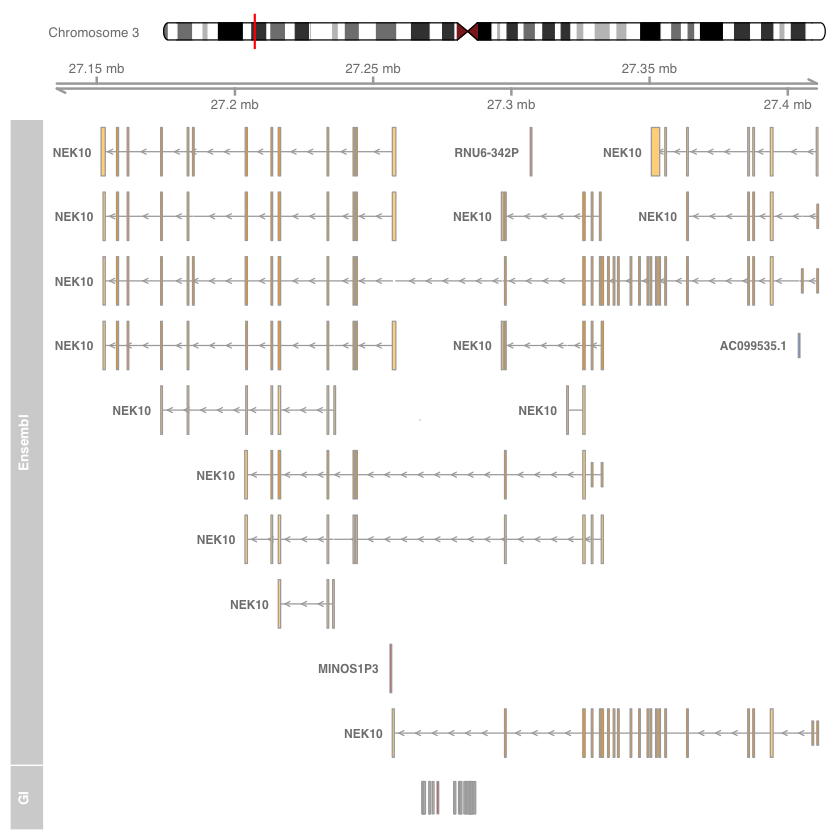

In [17]:
mapN10 <- map %>%
        filter(chr != 10)

giTrack <- getSnpTrack(mapN10, mapN10$gi, "GI")

itrack <- IdeogramTrack(genome = genome(giTrack), chromosome = names(genome(giTrack)))
gtrack <- GenomeAxisTrack()

biomTrack <- BiomartGeneRegionTrack(genome = "hg19", 
                                    chromosome = names(genome(giTrack)),
                                    start = min(start(range(giTrack))), 
                                    end = max(end(range(giTrack))), 
                                    name="Ensembl")

plotTracks(list(itrack, gtrack, biomTrack, giTrack), showId = TRUE,
           Selected = "red", Unselected = "grey80")

# gin

In [18]:
library(tidyverse)
library(magrittr)

gs <- read_tsv("../results/gin/gs_skat_aicc/gin_gs.out.txt", 
               col_names = F,  comment = "#", col_types = "ciiid") %>%
    set_colnames(c("id", "chr", "gpos", "selected", "skat")) %>%
    filter(selected == 1)

gm <- read_tsv("../results/gin/gm_skat_aicc/gin_gm.out.txt", 
               col_names = F,  comment = "#", col_types = "ciiid") %>%
    set_colnames(c("id", "chr", "gpos", "selected", "skat")) %>%
    filter(selected == 1)

gi <- read_tsv("../results/gin/gi_skat_aicc/gin_gi.out.txt", 
               col_names = F,  comment = "#", col_types = "ciiid") %>%
    set_colnames(c("id", "chr", "gpos", "selected", "skat")) %>%
    filter(selected == 1)

map <- read_tsv("../datasets/genesis/genesis.processed.map", 
                col_names = F, col_types = "icii") %>%
        set_colnames(c("chr","id","X","gpos")) %>% 
        arrange(chr, gpos) %>%
        mutate(gs = id %in% gs$id,
               gi = id %in% gi$id,
               gm = id %in% gm$id)

In [19]:
nrow(gs)
nrow(gm)
nrow(gi)

[1] 264

[1] 264

[1] 264

In [20]:
c(gs$id, gm$id, gi$id) %>% unique %>% length

[1] 264

All 3 networks yield the same results. The GM and GI network do not seem to yield better results.